# MadMiner particle physics tutorial

# Part C1: Likelihood Module: no systematics

Johann Brehmer, Felix Kling, Irina Espejo, and Kyle Cranmer 2018-2019

In this notebook, we use the Likelihood class for a process without any systematics. 

## 0. Preparations

In [1]:
import sys
import os
madminer_src_path = "/Users/felixkling/Documents/GitHub/madminer"
sys.path.append(madminer_src_path)

from __future__ import absolute_import, division, print_function, unicode_literals

import logging
import numpy as np
import time
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

# MadMiner output
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

from madminer.likelihood import NeuralLikelihood, HistoLikelihood, project_log_likelihood, profile_log_likelihood
from madminer.limits import AsymptoticLimits
from madminer.plotting import plot_pvalue_limits

22:47 madminer             INFO    
22:47 madminer             INFO    ------------------------------------------------------------------------
22:47 madminer             INFO    |                                                                      |
22:47 madminer             INFO    |  MadMiner v0.6.3                                                     |
22:47 madminer             INFO    |                                                                      |
22:47 madminer             INFO    |         Johann Brehmer, Felix Kling, Irina Espejo, and Kyle Cranmer  |
22:47 madminer             INFO    |                                                                      |
22:47 madminer             INFO    ------------------------------------------------------------------------
22:47 madminer             INFO    


We define the grid and luminosity 

In [2]:
grid_ranges = [(-1, 1.), (-1, 1.)]
grid_resolutions = [10, 10]

In [3]:
lumi = 300.*1000. 
n_asimov=10000
n_histo_toys=50000

In [4]:
do_load=True

if do_load:
    p_values,mle,durations = np.load("limits/c1.npy")
else:
    p_values = {}
    mle = {}
    durations = {}

## 1. Using AsymptoticLimits class

For comparisson, let's use the `AsymptoticLimits` class again. 

In [15]:
limits = AsymptoticLimits('data/lhe_data_shuffled.h5')

22:31 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
22:31 madminer.analysis    INFO    Found 2 parameters
22:31 madminer.analysis    INFO    Did not find nuisance parameters
22:31 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
22:31 madminer.analysis    INFO    Found 3 observables
22:31 madminer.analysis    INFO    Found 539913 events
22:31 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
22:31 madminer.analysis    INFO      10000 signal events sampled from benchmark w
22:31 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
22:31 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
22:31 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
22:31 madminer.analysis    INFO    Found morphing setup with 6 components
22:31 madminer.analysis    INFO    Did not find nuisance morphing setup


Now we calculate the limits for the choosen grid using
- the full likelihood ratio estimated by the ALICES method
- the score estimated using the SALLY method
- a "pt_j1" histogram with fixed bins
- the rate 

### a) ALICES 

In [6]:
start_time = time.time()
theta_grid, p_values_expected, best_fit_expected, llr_kin, _, _ = limits.expected_limits(
    mode="ml",
    model_file='models/alices',
    theta_true=[0.,0.],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    luminosity=lumi,
    include_xsec=False,
    n_asimov=n_asimov,
)
duration = time.time()-start_time

p_values["AL: ALICES"] = p_values_expected
mle["AL: ALICES"] = best_fit_expected
durations["AL: ALICES"] = duration

21:32 madminer.limits      INFO    Generating Asimov data
21:32 madminer.limits      INFO    Expected events: 313.1522825343162
21:32 madminer.limits      INFO    Calculating p-values for 313.1522825343162 expected events in mode ml without rate information
21:32 madminer.limits      INFO    Evaluating likelihood on a regular grid with 100 parameter points
21:32 madminer.limits      INFO    Loading kinematic likelihood ratio estimator
21:32 madminer.ml          INFO    Loading model from models/alices
21:32 madminer.limits      INFO    Calculating kinematic log likelihood ratio with estimator
21:32 madminer.limits      INFO    Calculating p-values


### b) SALLY

In [7]:
start_time = time.time()
theta_grid, p_values_expected, best_fit_expected, llr_kin, _, _ = limits.expected_limits(
    mode="sally",
    model_file='models/sally',
    theta_true=[0.,0.],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    luminosity=lumi,
    include_xsec=False,
    n_asimov=n_asimov,
    n_histo_toys=n_histo_toys,
    hist_bins=[5,5],
)
duration = time.time()-start_time

p_values["AL: SALLY"] = p_values_expected
mle["AL: SALLY"] = best_fit_expected
durations["AL: SALLY"] = duration

21:32 madminer.limits      INFO    Generating Asimov data
21:32 madminer.limits      INFO    Expected events: 313.1522825343162
21:32 madminer.limits      INFO    Calculating p-values for 313.1522825343162 expected events in mode sally without rate information
21:32 madminer.limits      INFO    Evaluating likelihood on a regular grid with 100 parameter points
21:32 madminer.limits      INFO    Loading score estimator and setting all components up as summary statistics
21:32 madminer.ml          INFO    Loading model from models/sally
21:32 madminer.limits      INFO    Creating histograms of 2 summary statistics. Using [5, 5] bins each, or 25 in total.
21:32 madminer.limits      INFO    Determining fixed adaptive histogram binning for all points on grid
21:33 madminer.limits      INFO    Calculating kinematic log likelihood with histograms
21:33 madminer.limits      INFO    Calculating p-values


### c) Histogram

In [8]:
start_time = time.time()
theta_grid, p_values_expected, best_fit_expected, llr_kin, _, _ = limits.expected_limits(
    mode="histo",
    hist_vars=["pt_j1"],
    hist_bins=[[20,100,200,300,400,500]],
    theta_true=[0.,0.],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    luminosity=lumi,
    include_xsec=False,
    n_asimov=n_asimov,
    n_histo_toys=n_histo_toys,
)
duration = time.time()-start_time

p_values["AL: Histo"] = p_values_expected
mle["AL: Histo"] = best_fit_expected
durations["AL: Histo"] = duration

21:33 madminer.limits      INFO    Generating Asimov data
21:33 madminer.limits      INFO    Expected events: 313.1522825343162
21:33 madminer.limits      INFO    Calculating p-values for 313.1522825343162 expected events in mode histo without rate information
21:33 madminer.limits      INFO    Evaluating likelihood on a regular grid with 100 parameter points
21:33 madminer.limits      INFO    Setting up standard summary statistics
21:33 madminer.limits      INFO    Creating histograms of 1 summary statistics. Using [5] bins each, or 5 in total.
21:33 madminer.limits      INFO    Calculating kinematic log likelihood with histograms
21:33 madminer.limits      INFO    Calculating p-values


### d) Rate

In [16]:
start_time = time.time()
theta_grid, p_values_expected, best_fit_expected, llr_kin, _, _ = limits.expected_limits(
    mode="rate",
    theta_true=[0.,0.],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    luminosity=lumi,
    include_xsec=True,
)
duration = time.time()-start_time

p_values["AL: Rate"] = p_values_expected
mle["AL: Rate"] = best_fit_expected
durations["AL: Rate"] = duration

22:31 madminer.limits      INFO    Generating Asimov data
22:31 madminer.limits      INFO    Expected events: 313.1522825343162
22:31 madminer.limits      INFO    Calculating p-values for 313.1522825343162 expected events in mode rate including rate information
22:31 madminer.limits      INFO    Evaluating likelihood on a regular grid with 100 parameter points
22:31 madminer.limits      INFO    Calculating rate log likelihood
22:31 madminer.limits      INFO    Calculating p-values


## 2. Using Likelihood class - Unweighted

We can also use the new Likelihood class to obtain limits. There are to main classes, the `NeuralLikelihood` and `HistoLikelihood` class. First, let's initialize both classes

In [5]:
neurallikelihood = NeuralLikelihood("data/lhe_data_shuffled.h5")
histolikelihood = HistoLikelihood("data/lhe_data_shuffled.h5")

22:47 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
22:47 madminer.analysis    INFO    Found 2 parameters
22:47 madminer.analysis    INFO    Did not find nuisance parameters
22:47 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
22:47 madminer.analysis    INFO    Found 3 observables
22:47 madminer.analysis    INFO    Found 539913 events
22:47 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
22:47 madminer.analysis    INFO      10000 signal events sampled from benchmark w
22:47 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
22:47 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
22:47 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
22:47 madminer.analysis    INFO    Found morphing setup with 6 components
22:47 madminer.analysis    INFO    Did not find nuisance morphing setup
22:47 madminer.analysis    INFO    Loading dat

We can now create a function which returns the expected negative log likelihood $-\mathrm{E}[\log p(x|\theta) | \theta_{\text{true}}]$ using the function `create_expected_negative_log_likelihood()`. This function is evaluated in a grid using `project_log_likelihood()`. Let us again do this for ALICES, SALLY, a histogram and the rate.

**Note:** Here we use the `sampled` mode when calculating the likelihood function. This means that at every point we separatly evaulate the rate and sample a set of events to fill histograms. This setup is therefore expected to be slow. 

### a) ALICES

In [11]:
start_time = time.time()
nll_alices = neurallikelihood.create_expected_negative_log_likelihood(
    n_asimov=n_asimov,
    include_xsec=False,
    luminosity=lumi,
    theta_true=np.array([0,0]),
    nu_true=None,
    model_file="models/alices",
)

theta_grid, p_values_expected, best_fit_expected, llr = project_log_likelihood(
    negative_log_likelihood=nll_alices,
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
)
duration = time.time()-start_time

p_values["LHS: ALICES"] = p_values_expected
mle["LHS: ALICES"] = best_fit_expected
durations["LHS: ALICES"] = duration

21:33 madminer.ml          INFO    Loading model from models/alices


### b) SALLY

In [12]:
start_time = time.time()
nll_sally = histolikelihood.create_expected_negative_log_likelihood(
    n_asimov=n_asimov,
    include_xsec=False,
    luminosity=lumi,
    theta_true=np.array([0,0]),
    nu_true=None,
    score_components=[0,1],
    model_file="models/sally",
    hist_bins=[5,5],
    mode="sampled",
    n_histo_toys=n_histo_toys,
)

theta_grid, p_values_expected, best_fit_expected, llr = project_log_likelihood(
    negative_log_likelihood=nll_sally,
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
)
duration = time.time()-start_time

p_values["LHS: SALLY"] = p_values_expected
mle["LHS: SALLY"] = best_fit_expected
durations["LHS: SALLY"] = duration

21:33 madminer.ml          INFO    Loading model from models/sally
21:33 madminer.likelihood  INFO    Setting up standard summary statistics
21:33 madminer.likelihood  INFO    Use binning: [array([-6.58443577, -0.14503346,  0.10299816,  0.22821279,  0.30819729,
        0.37687759]), array([-3.26759938, -0.34914851, -0.10940249,  0.10767836,  0.34632141,
        3.55171039])]
21:33 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
21:33 madminer.analysis    INFO    Found 2 parameters
21:33 madminer.analysis    INFO    Did not find nuisance parameters
21:33 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
21:33 madminer.analysis    INFO    Found 3 observables
21:33 madminer.analysis    INFO    Found 539913 events
21:33 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
21:33 madminer.analysis    INFO      10000 signal events sampled from benchmark w
21:33 madminer.analysis    INFO      10000 signal events sampled from 

21:35 madminer.analysis    INFO    Found 539913 events
21:35 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
21:35 madminer.analysis    INFO      10000 signal events sampled from benchmark w
21:35 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
21:35 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
21:35 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
21:35 madminer.analysis    INFO    Found morphing setup with 6 components
21:35 madminer.analysis    INFO    Did not find nuisance morphing setup
21:35 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [-1.          0.11111111]
21:35 madminer.sampling    INFO    Starting sampling serially
21:35 madminer.sampling    INFO    Sampling from parameter point 1 / 1
21:35 madminer.sampling    INFO    Effective number of samples: mean 553.2125757107707, with individual thetas ranging from 553

21:37 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
21:37 madminer.analysis    INFO    Found 2 parameters
21:37 madminer.analysis    INFO    Did not find nuisance parameters
21:37 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
21:37 madminer.analysis    INFO    Found 3 observables
21:37 madminer.analysis    INFO    Found 539913 events
21:37 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
21:37 madminer.analysis    INFO      10000 signal events sampled from benchmark w
21:37 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
21:37 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
21:37 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
21:37 madminer.analysis    INFO    Found morphing setup with 6 components
21:37 madminer.analysis    INFO    Did not find nuisance morphing setup
21:37 madminer.sampling    INFO    Extracting 

21:38 madminer.analysis    INFO    Did not find nuisance morphing setup
21:38 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [-0.77777778  0.33333333]
21:38 madminer.sampling    INFO    Starting sampling serially
21:38 madminer.sampling    INFO    Sampling from parameter point 1 / 1
21:39 madminer.sampling    INFO    Effective number of samples: mean 838.93835804063, with individual thetas ranging from 838.9383580406295 to 838.9383580406295
21:39 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
21:39 madminer.analysis    INFO    Found 2 parameters
21:39 madminer.analysis    INFO    Did not find nuisance parameters
21:39 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
21:39 madminer.analysis    INFO    Found 3 observables
21:39 madminer.analysis    INFO    Found 539913 events
21:39 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
21:39 madminer.analysis    INFO      10000 sign

21:40 madminer.analysis    INFO      10000 signal events sampled from benchmark w
21:40 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
21:40 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
21:40 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
21:40 madminer.analysis    INFO    Found morphing setup with 6 components
21:40 madminer.analysis    INFO    Did not find nuisance morphing setup
21:40 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [-0.55555556 -0.55555556]
21:40 madminer.sampling    INFO    Starting sampling serially
21:40 madminer.sampling    INFO    Sampling from parameter point 1 / 1
21:40 madminer.sampling    WARNING Large statistical uncertainty on the total cross section when sampling from theta = [-0.5555556 -0.5555556]: (0.001375 +/- 0.000145) pb (10.542631892100937 %). Skipping these warnings in the future...
21:40 madminer.sampling    INF

21:42 madminer.analysis    INFO    Found 3 observables
21:42 madminer.analysis    INFO    Found 539913 events
21:42 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
21:42 madminer.analysis    INFO      10000 signal events sampled from benchmark w
21:42 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
21:42 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
21:42 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
21:42 madminer.analysis    INFO    Found morphing setup with 6 components
21:42 madminer.analysis    INFO    Did not find nuisance morphing setup
21:42 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [-0.55555556  0.77777778]
21:42 madminer.sampling    INFO    Starting sampling serially
21:42 madminer.sampling    INFO    Sampling from parameter point 1 / 1
21:42 madminer.sampling    INFO    Effective number of samples: mean 586

21:44 madminer.sampling    INFO    Effective number of samples: mean 1061.3760636451223, with individual thetas ranging from 1061.376063645122 to 1061.376063645122
21:44 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
21:44 madminer.analysis    INFO    Found 2 parameters
21:44 madminer.analysis    INFO    Did not find nuisance parameters
21:44 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
21:44 madminer.analysis    INFO    Found 3 observables
21:44 madminer.analysis    INFO    Found 539913 events
21:44 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
21:44 madminer.analysis    INFO      10000 signal events sampled from benchmark w
21:44 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
21:44 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
21:44 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
21:44 madminer.analysis    I

21:46 madminer.sampling    INFO    Effective number of samples: mean 380.58851744002925, with individual thetas ranging from 380.58851744002925 to 380.58851744002925
21:46 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
21:46 madminer.analysis    INFO    Found 2 parameters
21:46 madminer.analysis    INFO    Did not find nuisance parameters
21:46 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
21:46 madminer.analysis    INFO    Found 3 observables
21:46 madminer.analysis    INFO    Found 539913 events
21:46 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
21:46 madminer.analysis    INFO      10000 signal events sampled from benchmark w
21:46 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
21:46 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
21:46 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
21:46 madminer.analysis   

21:47 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
21:47 madminer.analysis    INFO    Found morphing setup with 6 components
21:47 madminer.analysis    INFO    Did not find nuisance morphing setup
21:47 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [-0.11111111  0.11111111]
21:47 madminer.sampling    INFO    Starting sampling serially
21:47 madminer.sampling    INFO    Sampling from parameter point 1 / 1
21:47 madminer.sampling    INFO    Effective number of samples: mean 16640.357355517426, with individual thetas ranging from 16640.357355517433 to 16640.357355517433
21:48 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
21:48 madminer.analysis    INFO    Found 2 parameters
21:48 madminer.analysis    INFO    Did not find nuisance parameters
21:48 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
21:48 madminer.analysis    INFO    Found 3 observables
21:48 madminer.analy

21:49 madminer.analysis    INFO      10000 signal events sampled from benchmark w
21:49 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
21:49 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
21:49 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
21:49 madminer.analysis    INFO    Found morphing setup with 6 components
21:49 madminer.analysis    INFO    Did not find nuisance morphing setup
21:49 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [ 0.11111111 -0.77777778]
21:49 madminer.sampling    INFO    Starting sampling serially
21:49 madminer.sampling    INFO    Sampling from parameter point 1 / 1
21:49 madminer.sampling    INFO    Effective number of samples: mean 461.5015461060185, with individual thetas ranging from 461.50154610601857 to 461.50154610601857
21:49 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
21:49 madminer.analysi

21:51 madminer.analysis    INFO      10000 signal events sampled from benchmark w
21:51 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
21:51 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
21:51 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
21:51 madminer.analysis    INFO    Found morphing setup with 6 components
21:51 madminer.analysis    INFO    Did not find nuisance morphing setup
21:51 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [0.11111111 0.55555556]
21:51 madminer.sampling    INFO    Starting sampling serially
21:51 madminer.sampling    INFO    Sampling from parameter point 1 / 1
21:51 madminer.sampling    INFO    Effective number of samples: mean 770.1659563953114, with individual thetas ranging from 770.1659563953115 to 770.1659563953115
21:51 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
21:51 madminer.analysis   

21:53 madminer.analysis    INFO      10000 signal events sampled from benchmark w
21:53 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
21:53 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
21:53 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
21:53 madminer.analysis    INFO    Found morphing setup with 6 components
21:53 madminer.analysis    INFO    Did not find nuisance morphing setup
21:53 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [ 0.33333333 -0.33333333]
21:53 madminer.sampling    INFO    Starting sampling serially
21:53 madminer.sampling    INFO    Sampling from parameter point 1 / 1
21:53 madminer.sampling    INFO    Effective number of samples: mean 1786.1823126895838, with individual thetas ranging from 1786.1823126895845 to 1786.1823126895845
21:53 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
21:53 madminer.analys

21:54 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
21:54 madminer.analysis    INFO      10000 signal events sampled from benchmark w
21:54 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
21:54 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
21:54 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
21:54 madminer.analysis    INFO    Found morphing setup with 6 components
21:54 madminer.analysis    INFO    Did not find nuisance morphing setup
21:54 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [0.33333333 1.        ]
21:54 madminer.sampling    INFO    Starting sampling serially
21:54 madminer.sampling    INFO    Sampling from parameter point 1 / 1
21:55 madminer.sampling    INFO    Effective number of samples: mean 225.59030037427473, with individual thetas ranging from 225.59030037427482 to 225.59030037427482
21:55 madminer.ana

21:56 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
21:56 madminer.analysis    INFO      10000 signal events sampled from benchmark w
21:56 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
21:56 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
21:56 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
21:56 madminer.analysis    INFO    Found morphing setup with 6 components
21:56 madminer.analysis    INFO    Did not find nuisance morphing setup
21:56 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [0.55555556 0.11111111]
21:56 madminer.sampling    INFO    Starting sampling serially
21:56 madminer.sampling    INFO    Sampling from parameter point 1 / 1
21:56 madminer.sampling    INFO    Effective number of samples: mean 875.4727612540099, with individual thetas ranging from 875.4727612540099 to 875.4727612540099
21:57 madminer.analys

21:58 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
21:58 madminer.analysis    INFO    Found 3 observables
21:58 madminer.analysis    INFO    Found 539913 events
21:58 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
21:58 madminer.analysis    INFO      10000 signal events sampled from benchmark w
21:58 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
21:58 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
21:58 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
21:58 madminer.analysis    INFO    Found morphing setup with 6 components
21:58 madminer.analysis    INFO    Did not find nuisance morphing setup
21:58 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [ 0.77777778 -0.77777778]
21:58 madminer.sampling    INFO    Starting sampling serially
21:58 madminer.sampling    INFO    Sampling from parameter point 1 /

22:00 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
22:00 madminer.analysis    INFO    Found 3 observables
22:00 madminer.analysis    INFO    Found 539913 events
22:00 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
22:00 madminer.analysis    INFO      10000 signal events sampled from benchmark w
22:00 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
22:00 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
22:00 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
22:00 madminer.analysis    INFO    Found morphing setup with 6 components
22:00 madminer.analysis    INFO    Did not find nuisance morphing setup
22:00 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [0.77777778 0.55555556]
22:00 madminer.sampling    INFO    Starting sampling serially
22:00 madminer.sampling    INFO    Sampling from parameter point 1 / 1

22:01 madminer.sampling    INFO    Sampling from parameter point 1 / 1
22:01 madminer.sampling    INFO    Effective number of samples: mean 316.7951624145367, with individual thetas ranging from 316.79516241453666 to 316.79516241453666
22:02 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
22:02 madminer.analysis    INFO    Found 2 parameters
22:02 madminer.analysis    INFO    Did not find nuisance parameters
22:02 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
22:02 madminer.analysis    INFO    Found 3 observables
22:02 madminer.analysis    INFO    Found 539913 events
22:02 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
22:02 madminer.analysis    INFO      10000 signal events sampled from benchmark w
22:02 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
22:02 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
22:02 madminer.analysis    INFO      10000 

22:03 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
22:03 madminer.analysis    INFO    Found morphing setup with 6 components
22:03 madminer.analysis    INFO    Did not find nuisance morphing setup
22:03 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [1.         0.77777778]
22:03 madminer.sampling    INFO    Starting sampling serially
22:03 madminer.sampling    INFO    Sampling from parameter point 1 / 1
22:03 madminer.sampling    WARNING Large statistical uncertainty on the total cross section when sampling from theta = [1.        0.7777778]: (0.000995 +/- 0.000141) pb (14.147458776395247 %). Skipping these warnings in the future...
22:03 madminer.sampling    INFO    Effective number of samples: mean 141.2520133803712, with individual thetas ranging from 141.25201338037127 to 141.25201338037127
22:04 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
22:04 madminer.analysis    INFO    Found 

### c) Histogram

In [13]:
start_time = time.time()
nll_hist = histolikelihood.create_expected_negative_log_likelihood(
    n_asimov=n_asimov,
    include_xsec=False,
    luminosity=lumi,
    theta_true=np.array([0,0]),
    nu_true=None,
    observables=["pt_j1"],
    hist_bins=[[20,100,200,300,400,500]],
    mode="sampled",
    n_histo_toys=n_histo_toys,
)

theta_grid, p_values_expected, best_fit_expected, llr = project_log_likelihood(
    negative_log_likelihood=nll_hist,
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
)
duration = time.time()-start_time

p_values["LHS: Histo"] = p_values_expected
mle["LHS: Histo"] = best_fit_expected
durations["LHS: Histo"] = duration

22:04 madminer.likelihood  INFO    Setting up standard summary statistics
22:04 madminer.likelihood  INFO    Use binning: [[20, 100, 200, 300, 400, 500]]
22:04 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
22:04 madminer.analysis    INFO    Found 2 parameters
22:04 madminer.analysis    INFO    Did not find nuisance parameters
22:04 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
22:04 madminer.analysis    INFO    Found 3 observables
22:04 madminer.analysis    INFO    Found 539913 events
22:04 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
22:04 madminer.analysis    INFO      10000 signal events sampled from benchmark w
22:04 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
22:04 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
22:04 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
22:04 madminer.analysis    INFO    Fou

22:04 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
22:04 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
22:04 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
22:04 madminer.analysis    INFO    Found morphing setup with 6 components
22:04 madminer.analysis    INFO    Did not find nuisance morphing setup
22:04 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [-1.          0.11111111]
22:04 madminer.sampling    INFO    Starting sampling serially
22:04 madminer.sampling    INFO    Sampling from parameter point 1 / 1
22:04 madminer.sampling    INFO    Effective number of samples: mean 553.2125757107707, with individual thetas ranging from 553.2125757107709 to 553.2125757107709
22:04 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
22:04 madminer.analysis    INFO    Found 2 parameters
22:04 madminer.analysis    INFO    Did not find nuis

22:04 madminer.analysis    INFO    Found 3 observables
22:04 madminer.analysis    INFO    Found 539913 events
22:04 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
22:04 madminer.analysis    INFO      10000 signal events sampled from benchmark w
22:04 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
22:04 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
22:04 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
22:04 madminer.analysis    INFO    Found morphing setup with 6 components
22:04 madminer.analysis    INFO    Did not find nuisance morphing setup
22:04 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [-0.77777778 -0.77777778]
22:04 madminer.sampling    INFO    Starting sampling serially
22:04 madminer.sampling    INFO    Sampling from parameter point 1 / 1
22:04 madminer.sampling    WARNING Large statistical uncertainty on the 

22:04 madminer.sampling    INFO    Effective number of samples: mean 838.93835804063, with individual thetas ranging from 838.9383580406295 to 838.9383580406295
22:04 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
22:04 madminer.analysis    INFO    Found 2 parameters
22:04 madminer.analysis    INFO    Did not find nuisance parameters
22:04 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
22:04 madminer.analysis    INFO    Found 3 observables
22:04 madminer.analysis    INFO    Found 539913 events
22:04 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
22:04 madminer.analysis    INFO      10000 signal events sampled from benchmark w
22:04 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
22:04 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
22:04 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
22:04 madminer.analysis    INFO

22:04 madminer.analysis    INFO    Found morphing setup with 6 components
22:04 madminer.analysis    INFO    Did not find nuisance morphing setup
22:04 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [-0.55555556 -0.55555556]
22:04 madminer.sampling    INFO    Starting sampling serially
22:04 madminer.sampling    INFO    Sampling from parameter point 1 / 1
22:04 madminer.sampling    WARNING Large statistical uncertainty on the total cross section when sampling from theta = [-0.5555556 -0.5555556]: (0.001375 +/- 0.000145) pb (10.542631892100937 %). Skipping these warnings in the future...
22:04 madminer.sampling    INFO    Effective number of samples: mean 448.92424179593206, with individual thetas ranging from 448.92424179593183 to 448.92424179593183
22:04 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
22:04 madminer.analysis    INFO    Found 2 parameters
22:04 madminer.analysis    INFO    Did not find nuisance parameters
2

22:04 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
22:04 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
22:04 madminer.analysis    INFO    Found morphing setup with 6 components
22:04 madminer.analysis    INFO    Did not find nuisance morphing setup
22:04 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [-0.55555556  0.77777778]
22:04 madminer.sampling    INFO    Starting sampling serially
22:04 madminer.sampling    INFO    Sampling from parameter point 1 / 1
22:04 madminer.sampling    INFO    Effective number of samples: mean 586.091296042241, with individual thetas ranging from 586.0912960422409 to 586.0912960422409
22:04 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
22:04 madminer.analysis    INFO    Found 2 parameters
22:04 madminer.analysis    INFO    Did not find nuisance parameters
22:04 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physi

22:04 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
22:04 madminer.analysis    INFO    Found 3 observables
22:04 madminer.analysis    INFO    Found 539913 events
22:04 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
22:04 madminer.analysis    INFO      10000 signal events sampled from benchmark w
22:04 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
22:04 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
22:04 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
22:04 madminer.analysis    INFO    Found morphing setup with 6 components
22:04 madminer.analysis    INFO    Did not find nuisance morphing setup
22:04 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [-0.33333333 -0.11111111]
22:04 madminer.sampling    INFO    Starting sampling serially
22:04 madminer.sampling    INFO    Sampling from parameter point 1 /

22:04 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
22:04 madminer.analysis    INFO    Found 3 observables
22:04 madminer.analysis    INFO    Found 539913 events
22:04 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
22:04 madminer.analysis    INFO      10000 signal events sampled from benchmark w
22:04 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
22:04 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
22:04 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
22:04 madminer.analysis    INFO    Found morphing setup with 6 components
22:04 madminer.analysis    INFO    Did not find nuisance morphing setup
22:04 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [-0.11111111 -1.        ]
22:04 madminer.sampling    INFO    Starting sampling serially
22:04 madminer.sampling    INFO    Sampling from parameter point 1 /

22:04 madminer.sampling    INFO    Sampling from parameter point 1 / 1
22:04 madminer.sampling    INFO    Effective number of samples: mean 16640.357355517426, with individual thetas ranging from 16640.357355517433 to 16640.357355517433
22:04 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
22:04 madminer.analysis    INFO    Found 2 parameters
22:04 madminer.analysis    INFO    Did not find nuisance parameters
22:04 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
22:04 madminer.analysis    INFO    Found 3 observables
22:04 madminer.analysis    INFO    Found 539913 events
22:04 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
22:04 madminer.analysis    INFO      10000 signal events sampled from benchmark w
22:04 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
22:04 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
22:04 madminer.analysis    INFO      10000

22:04 madminer.analysis    INFO    Did not find nuisance morphing setup
22:04 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [ 0.11111111 -0.77777778]
22:04 madminer.sampling    INFO    Starting sampling serially
22:04 madminer.sampling    INFO    Sampling from parameter point 1 / 1
22:04 madminer.sampling    INFO    Effective number of samples: mean 461.5015461060185, with individual thetas ranging from 461.50154610601857 to 461.50154610601857
22:04 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
22:04 madminer.analysis    INFO    Found 2 parameters
22:04 madminer.analysis    INFO    Did not find nuisance parameters
22:04 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
22:04 madminer.analysis    INFO    Found 3 observables
22:04 madminer.analysis    INFO    Found 539913 events
22:04 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
22:04 madminer.analysis    INFO      10000 

22:04 madminer.analysis    INFO    Did not find nuisance morphing setup
22:04 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [0.11111111 0.55555556]
22:04 madminer.sampling    INFO    Starting sampling serially
22:04 madminer.sampling    INFO    Sampling from parameter point 1 / 1
22:04 madminer.sampling    INFO    Effective number of samples: mean 770.1659563953114, with individual thetas ranging from 770.1659563953115 to 770.1659563953115
22:04 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
22:04 madminer.analysis    INFO    Found 2 parameters
22:04 madminer.analysis    INFO    Did not find nuisance parameters
22:04 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
22:04 madminer.analysis    INFO    Found 3 observables
22:04 madminer.analysis    INFO    Found 539913 events
22:04 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
22:04 madminer.analysis    INFO      10000 sign

22:04 madminer.analysis    INFO    Did not find nuisance morphing setup
22:04 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [ 0.33333333 -0.33333333]
22:04 madminer.sampling    INFO    Starting sampling serially
22:04 madminer.sampling    INFO    Sampling from parameter point 1 / 1
22:04 madminer.sampling    INFO    Effective number of samples: mean 1786.1823126895838, with individual thetas ranging from 1786.1823126895845 to 1786.1823126895845
22:04 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
22:04 madminer.analysis    INFO    Found 2 parameters
22:04 madminer.analysis    INFO    Did not find nuisance parameters
22:04 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
22:04 madminer.analysis    INFO    Found 3 observables
22:04 madminer.analysis    INFO    Found 539913 events
22:04 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
22:04 madminer.analysis    INFO      10000

22:04 madminer.analysis    INFO    Found morphing setup with 6 components
22:04 madminer.analysis    INFO    Did not find nuisance morphing setup
22:04 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [0.33333333 1.        ]
22:04 madminer.sampling    INFO    Starting sampling serially
22:04 madminer.sampling    INFO    Sampling from parameter point 1 / 1
22:04 madminer.sampling    INFO    Effective number of samples: mean 225.59030037427473, with individual thetas ranging from 225.59030037427482 to 225.59030037427482
22:04 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
22:04 madminer.analysis    INFO    Found 2 parameters
22:04 madminer.analysis    INFO    Did not find nuisance parameters
22:04 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
22:04 madminer.analysis    INFO    Found 3 observables
22:04 madminer.analysis    INFO    Found 539913 events
22:04 madminer.analysis    INFO      499913 signal eve

22:04 madminer.analysis    INFO    Found morphing setup with 6 components
22:04 madminer.analysis    INFO    Did not find nuisance morphing setup
22:04 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [0.55555556 0.11111111]
22:04 madminer.sampling    INFO    Starting sampling serially
22:04 madminer.sampling    INFO    Sampling from parameter point 1 / 1
22:04 madminer.sampling    INFO    Effective number of samples: mean 875.4727612540099, with individual thetas ranging from 875.4727612540099 to 875.4727612540099
22:04 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
22:04 madminer.analysis    INFO    Found 2 parameters
22:04 madminer.analysis    INFO    Did not find nuisance parameters
22:04 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
22:04 madminer.analysis    INFO    Found 3 observables
22:04 madminer.analysis    INFO    Found 539913 events
22:04 madminer.analysis    INFO      499913 signal events

22:04 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
22:04 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
22:04 madminer.analysis    INFO    Found morphing setup with 6 components
22:04 madminer.analysis    INFO    Did not find nuisance morphing setup
22:04 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [ 0.77777778 -0.77777778]
22:04 madminer.sampling    INFO    Starting sampling serially
22:04 madminer.sampling    INFO    Sampling from parameter point 1 / 1
22:04 madminer.sampling    INFO    Effective number of samples: mean 339.22668928159624, with individual thetas ranging from 339.2266892815963 to 339.2266892815963
22:04 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
22:04 madminer.analysis    INFO    Found 2 parameters
22:04 madminer.analysis    INFO    Did not find nuisance parameters
22:04 madminer.analysis    INFO    Found 6 benchmarks, of which 6 phy

22:04 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
22:04 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
22:04 madminer.analysis    INFO    Found morphing setup with 6 components
22:04 madminer.analysis    INFO    Did not find nuisance morphing setup
22:04 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [0.77777778 0.55555556]
22:04 madminer.sampling    INFO    Starting sampling serially
22:04 madminer.sampling    INFO    Sampling from parameter point 1 / 1
22:04 madminer.sampling    INFO    Effective number of samples: mean 239.7732944516593, with individual thetas ranging from 239.7732944516593 to 239.7732944516593
22:04 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
22:04 madminer.analysis    INFO    Found 2 parameters
22:04 madminer.analysis    INFO    Did not find nuisance parameters
22:04 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physic

22:04 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
22:04 madminer.analysis    INFO    Found 3 observables
22:04 madminer.analysis    INFO    Found 539913 events
22:04 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
22:04 madminer.analysis    INFO      10000 signal events sampled from benchmark w
22:04 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
22:04 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
22:04 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
22:04 madminer.analysis    INFO    Found morphing setup with 6 components
22:04 madminer.analysis    INFO    Did not find nuisance morphing setup
22:04 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [ 1.         -0.33333333]
22:04 madminer.sampling    INFO    Starting sampling serially
22:04 madminer.sampling    INFO    Sampling from parameter point 1 /

22:04 madminer.sampling    INFO    Sampling from parameter point 1 / 1
22:04 madminer.sampling    WARNING Large statistical uncertainty on the total cross section when sampling from theta = [1.        0.7777778]: (0.000995 +/- 0.000141) pb (14.147458776395247 %). Skipping these warnings in the future...
22:04 madminer.sampling    INFO    Effective number of samples: mean 141.2520133803712, with individual thetas ranging from 141.25201338037127 to 141.25201338037127
22:04 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
22:04 madminer.analysis    INFO    Found 2 parameters
22:04 madminer.analysis    INFO    Did not find nuisance parameters
22:04 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
22:04 madminer.analysis    INFO    Found 3 observables
22:04 madminer.analysis    INFO    Found 539913 events
22:04 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
22:04 madminer.analysis    INFO      10000 signal events sam

### d) Rate

In [14]:
start_time = time.time()
nll_rate = histolikelihood.create_expected_negative_log_likelihood(
    n_asimov=n_asimov,
    include_xsec=True,
    luminosity=lumi,
    theta_true=np.array([0,0]),
    nu_true=None,
    observables=None,
    mode="sampled",
)

theta_grid, p_values_expected, best_fit_expected, llr = project_log_likelihood(
    negative_log_likelihood=nll_rate,
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
)
duration = time.time()-start_time

p_values["LHS: Rate"] = p_values_expected
mle["LHS: Rate"] = best_fit_expected
durations["LHS: Rate"] = duration

22:04 madminer.likelihood  INFO    No observables and scores provided. Calculate LLR due to rate and set include_xsec=True.
22:04 madminer.likelihood  INFO    Setting up standard summary statistics
22:04 madminer.likelihood  INFO    Use binning: None


## 3. Using Likelihood class - Unweighted

How let's use the `mode=weighted` mode when calculating the likelihood function. This means that we first create a set of unweighted events. Later, these events are used to calculate the cross section and create the histograms for each parameter point. This setup is expected to be faster. 

### a) ALICES

In [11]:
start_time = time.time()
nll_alices = neurallikelihood.create_expected_negative_log_likelihood(
    n_asimov=n_asimov,
    include_xsec=False,
    luminosity=lumi,
    theta_true=np.array([0,0]),
    nu_true=None,
    model_file="models/alices",
    mode="weighted",
    n_weighted=n_histo_toys,
)

theta_grid, p_values_expected, best_fit_expected, llr = project_log_likelihood(
    negative_log_likelihood=nll_alices,
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
)
duration = time.time()-start_time

p_values["LHW: ALICES"] = p_values_expected
mle["LHW: ALICES"] = best_fit_expected
durations["LHW: ALICES"] = duration

22:51 madminer.ml          INFO    Loading model from models/alices


### b) SALLY

In [12]:
start_time = time.time()
nll_sally = histolikelihood.create_expected_negative_log_likelihood(
    n_asimov=n_asimov,
    include_xsec=False,
    luminosity=lumi,
    theta_true=np.array([0,0]),
    nu_true=None,
    score_components=[0,1],
    model_file="models/sally",
    hist_bins=[5,5],
    mode="weighted",
    n_histo_toys=n_histo_toys,
)

theta_grid, p_values_expected, best_fit_expected, llr = project_log_likelihood(
    negative_log_likelihood=nll_sally,
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
)
duration = time.time()-start_time

p_values["LHW: SALLY"] = p_values_expected
mle["LHW: SALLY"] = best_fit_expected
durations["LHW: SALLY"] = duration

22:51 madminer.ml          INFO    Loading model from models/sally
22:51 madminer.likelihood  INFO    Setting up standard summary statistics
22:51 madminer.likelihood  INFO    Getting weighted data
22:51 madminer.likelihood  INFO    Setting up binning
22:51 madminer.likelihood  INFO    Use binning: [array([-6.79714102, -0.14025076,  0.10280297,  0.23119697,  0.30997713,
        0.3775295 ]), array([-3.28376046, -0.33822725, -0.10113636,  0.11855287,  0.34713594,
        3.47992819])]


### c) Histogram

In [13]:
start_time = time.time()
nll_hist = histolikelihood.create_expected_negative_log_likelihood(
    n_asimov=n_asimov,
    include_xsec=False,
    luminosity=lumi,
    theta_true=np.array([0,0]),
    nu_true=None,
    observables=["pt_j1"],
    hist_bins=[[20,100,200,300,400,500]],
    mode="weighted",
    n_histo_toys=n_histo_toys,
)

theta_grid, p_values_expected, best_fit_expected, llr = project_log_likelihood(
    negative_log_likelihood=nll_hist,
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
)
duration = time.time()-start_time

p_values["LHW: Histo"] = p_values_expected
mle["LHW: Histo"] = best_fit_expected
durations["LHW: Histo"] = duration

22:51 madminer.likelihood  INFO    Setting up standard summary statistics
22:51 madminer.likelihood  INFO    Getting weighted data
22:51 madminer.likelihood  INFO    Setting up binning
22:51 madminer.likelihood  INFO    Use binning: [[20, 100, 200, 300, 400, 500]]


### d) Rate

In [14]:
start_time = time.time()
nll_rate = histolikelihood.create_expected_negative_log_likelihood(
    n_asimov=n_asimov,
    include_xsec=True,
    luminosity=lumi,
    theta_true=np.array([0,0]),
    nu_true=None,
    observables=None,
    mode="weighted",
    n_histo_toys=n_histo_toys,
)

theta_grid, p_values_expected, best_fit_expected, llr = project_log_likelihood(
    negative_log_likelihood=nll_rate,
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
)
duration = time.time()-start_time

p_values["LHW: Rate"] = p_values_expected
mle["LHW: Rate"] = best_fit_expected
durations["LHW: Rate"] = duration

22:51 madminer.likelihood  INFO    No observables and scores provided. Calculate LLR due to rate and set include_xsec=True.
22:51 madminer.likelihood  INFO    Setting up standard summary statistics
22:51 madminer.likelihood  INFO    Getting weighted data
22:51 madminer.likelihood  INFO    Setting up binning
22:51 madminer.likelihood  INFO    Use binning: None


## 3. Plot Results

Let's plot the results:

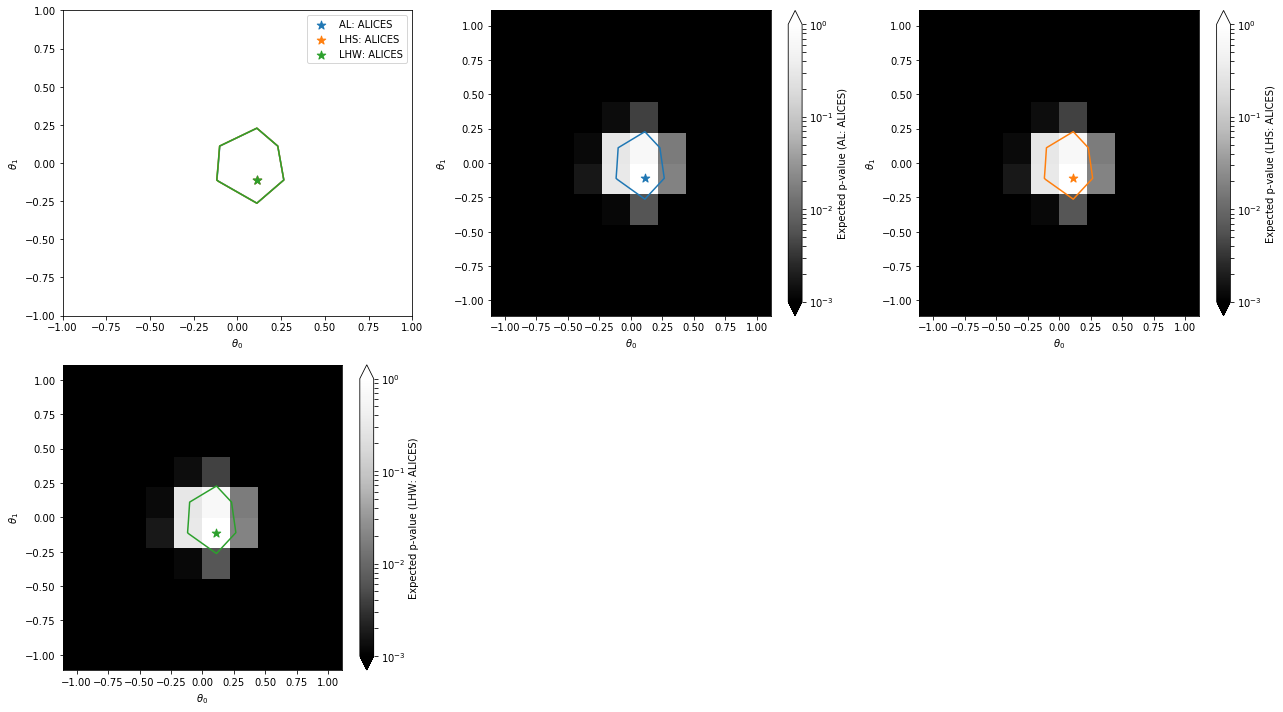

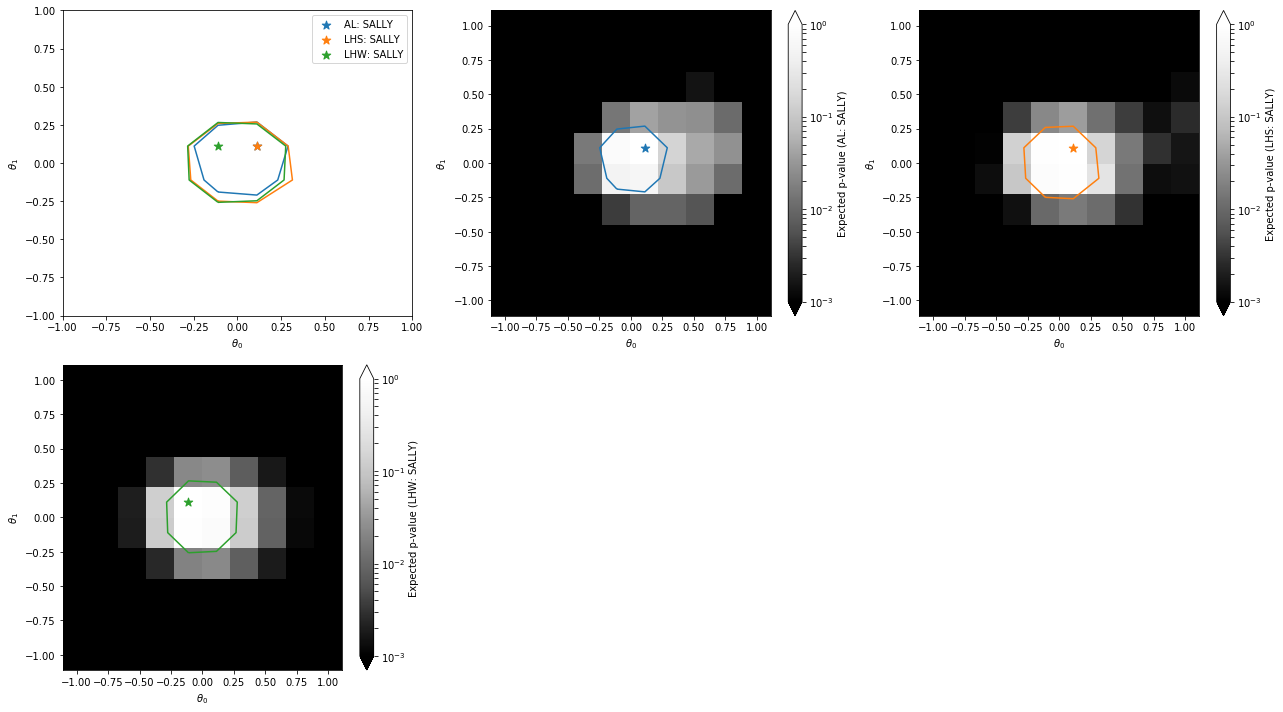

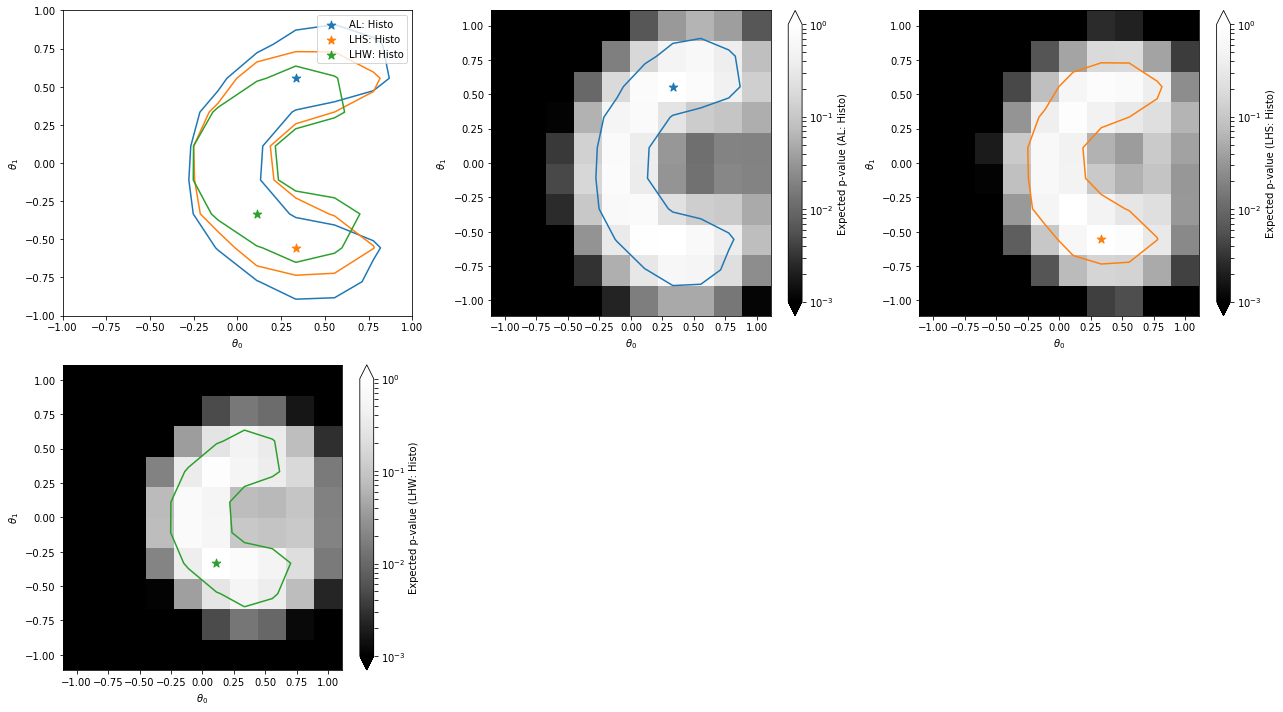

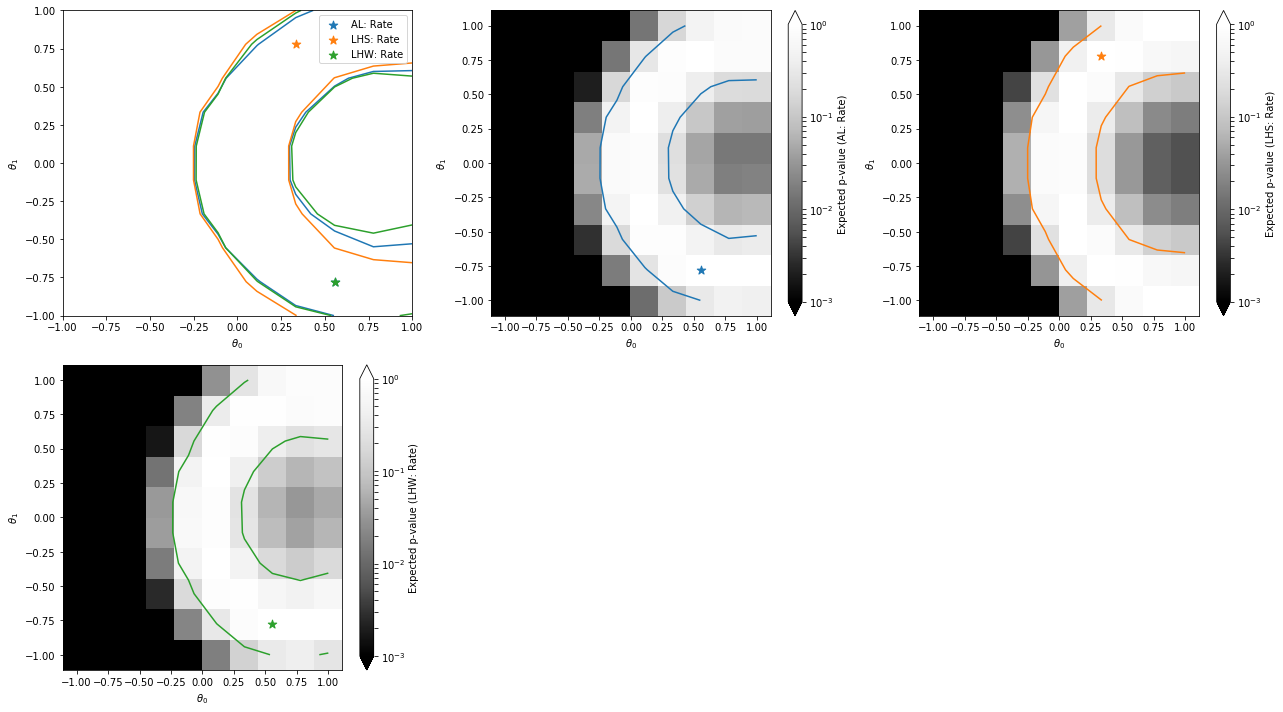

In [15]:
plot_pvalue_limits(
    p_values=p_values,
    best_fits=mle,
    labels=["AL: ALICES",  "LHS: ALICES", "LHW: ALICES"],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    single_plot=False,
)

plot_pvalue_limits(
    p_values=p_values,
    best_fits=mle,
    labels=["AL: SALLY",  "LHS: SALLY", "LHW: SALLY"],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    single_plot=False,
)

plot_pvalue_limits(
    p_values=p_values,
    best_fits=mle,
    labels=["AL: Histo",  "LHS: Histo", "LHW: Histo"],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    single_plot=False,
)

plot_pvalue_limits(
    p_values=p_values,
    best_fits=mle,
    labels=["AL: Rate",  "LHS: Rate", "LHW: Rate"],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    single_plot=False,
)

We can also look at the computation time:

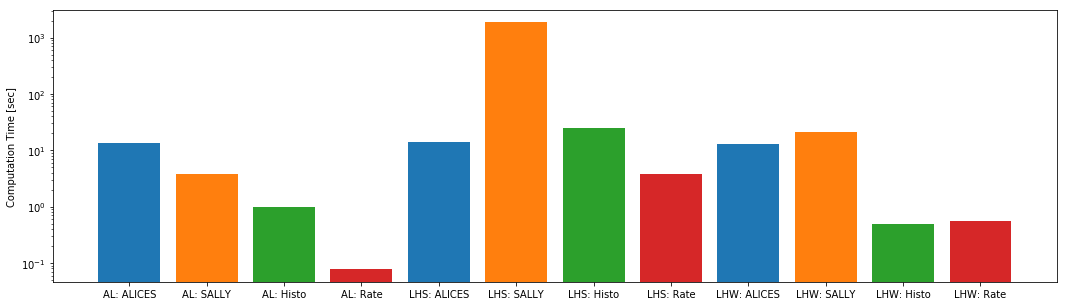

In [20]:
labels = ["AL: ALICES", "AL: SALLY", "AL: Histo", "AL: Rate", "LHS: ALICES", "LHS: SALLY", "LHS: Histo", "LHS: Rate",
            "LHW: ALICES", "LHW: SALLY", "LHW: Histo", "LHW: Rate"]
colors=['C0','C1','C2','C3','C0','C1','C2','C3','C0','C1','C2','C3']
times = [durations[str(label)] for label in labels]
indices = [i for i in range(len(labels))]

fig, ax = plt.subplots(figsize=(1.5*len(labels),5))
plt.bar(indices, times,color=colors)
plt.xticks(indices, labels)
plt.yscale("log")
plt.ylabel("Computation Time [sec]")
plt.show()

In [12]:
np.save("limits/c1.npy",[p_values,mle,durations])

## 4 Profile over one parameter

Let's look more closely rate. At first we calculate the expected p-value in a grid.

In [21]:
grid_ranges_rate = [(-1, 3.), (-1, 1.)]
grid_resolutions_rate = [20, 10]
theta_grid_rate, p_values_expected_rate, mle_rate , _ = project_log_likelihood(
    negative_log_likelihood=nll_rate,
    grid_ranges=grid_ranges_rate,
    grid_resolutions=grid_resolutions_rate,
)

We can also profile over a parameter using the function `profile_log_likelihood` to profile over the rate only likelihood function.

In [22]:
theta_grid_proj, p_values_expected_proj, best_fit_expected_proj, llr_proj = project_log_likelihood(
    negative_log_likelihood=nll_rate,
    grid_ranges=[(-1,3)],
    grid_resolutions=[50],
    remaining_components=[0],
)
theta_grid_prof, p_values_expected_prof, best_fit_expected_prof, llr_prof = profile_log_likelihood(
    negative_log_likelihood=nll_rate,
    grid_ranges=[(-1,3)],
    grid_resolutions=[50],
    remaining_components=[0],
    theta_start=np.array([0,0])
)

22:09 madminer.likelihood  INFO    Processed 1.0 % of parameter points in 0.2 seconds.
22:09 madminer.likelihood  INFO    Processed 2.0 % of parameter points in 0.5 seconds.
22:09 madminer.likelihood  INFO    Processed 4.0 % of parameter points in 0.9 seconds.
22:10 madminer.likelihood  INFO    Processed 6.0 % of parameter points in 1.2 seconds.
22:10 madminer.likelihood  INFO    Processed 8.0 % of parameter points in 1.3 seconds.
22:10 madminer.likelihood  INFO    Processed 20.0 % of parameter points in 4.1 seconds.
22:10 madminer.likelihood  INFO    Processed 30.0 % of parameter points in 6.2 seconds.
22:10 madminer.likelihood  INFO    Processed 40.0 % of parameter points in 8.1 seconds.
22:10 madminer.likelihood  INFO    Processed 50.0 % of parameter points in 10.3 seconds.
22:10 madminer.likelihood  INFO    Processed 60.0 % of parameter points in 13.0 seconds.
22:10 madminer.likelihood  INFO    Processed 70.0 % of parameter points in 14.9 seconds.
22:10 madminer.likelihood  INFO   

Let's now plot both the 2-dimensional and 1-dimensional result.

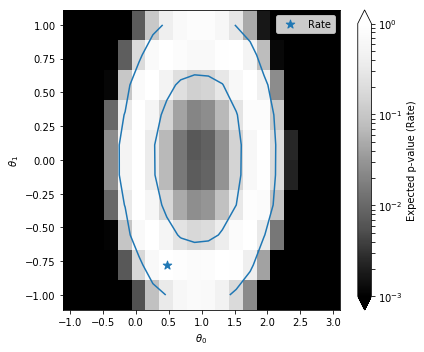

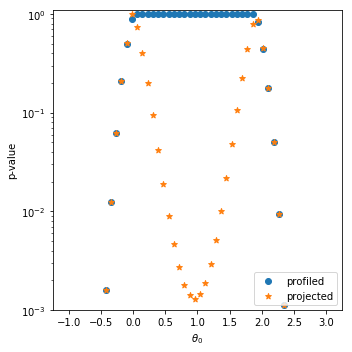

In [23]:
plot_pvalue_limits(
    p_values=np.array([p_values_expected_rate]),
    best_fits=np.array([mle_rate]),
    labels=["Rate"],
    grid_ranges=grid_ranges_rate,
    grid_resolutions=grid_resolutions_rate,
    show_index=0,
)

fig = plt.figure(figsize=(5,5))
plt.scatter(theta_grid_prof,p_values_expected_prof,label="profiled")
plt.scatter(theta_grid_proj,p_values_expected_proj,label="projected",marker="*")
plt.xlabel(r"$\theta_0$")
plt.ylabel("p-value")
plt.yscale("log")
plt.ylim(0.001,1.1)
plt.legend()
plt.tight_layout()
plt.show()

We can see that 2-dimensional has the shape of a donut - it has a blind direction where the rate is unchanged. If we project the likelihood in one dimension (so set the other parameter to zero) we obtain a double peak structue. However, if we properly profile of the other component, we get a plateau. This reflects that in the platau region we can find a value of $\theta$ that leads to the same rate and hence same likelihood as the SM reference point. 